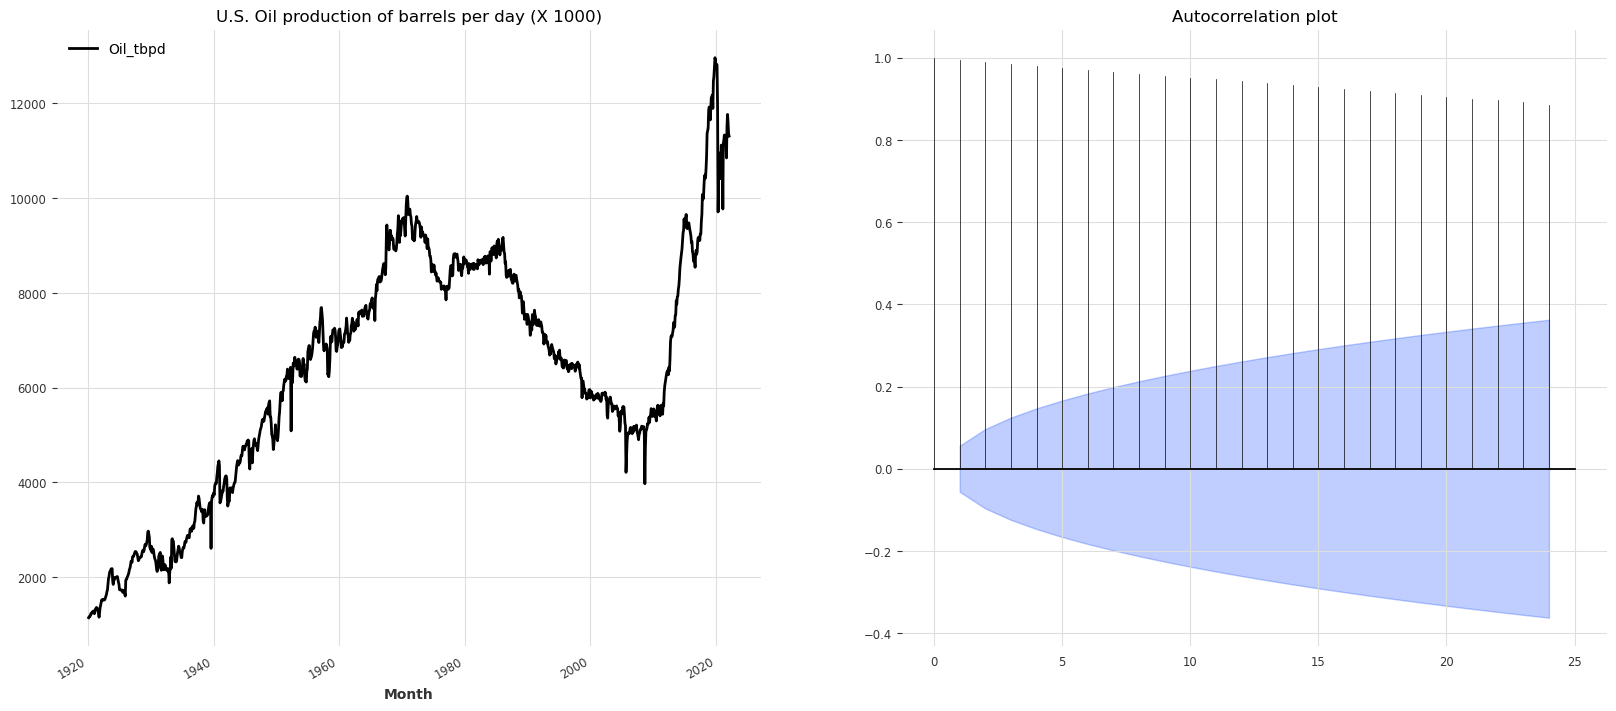

In [108]:
#LOADING IN THE DATA

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import darts
import darts.utils.statistics as ds

ts = darts.TimeSeries.from_csv('crudeOil.csv', time_col = 'Month')

fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ts.plot(ax= ax[0])
ax[0].set_title('U.S. Oil production of barrels per day (X 1000)')
ds.plot_acf(ts, axis= ax[1])
ax[1].set_title('Autocorrelation plot')

plt.show()

Stationarity p-value after subtracting trend and seasonality: 1.0669820416559084e-28


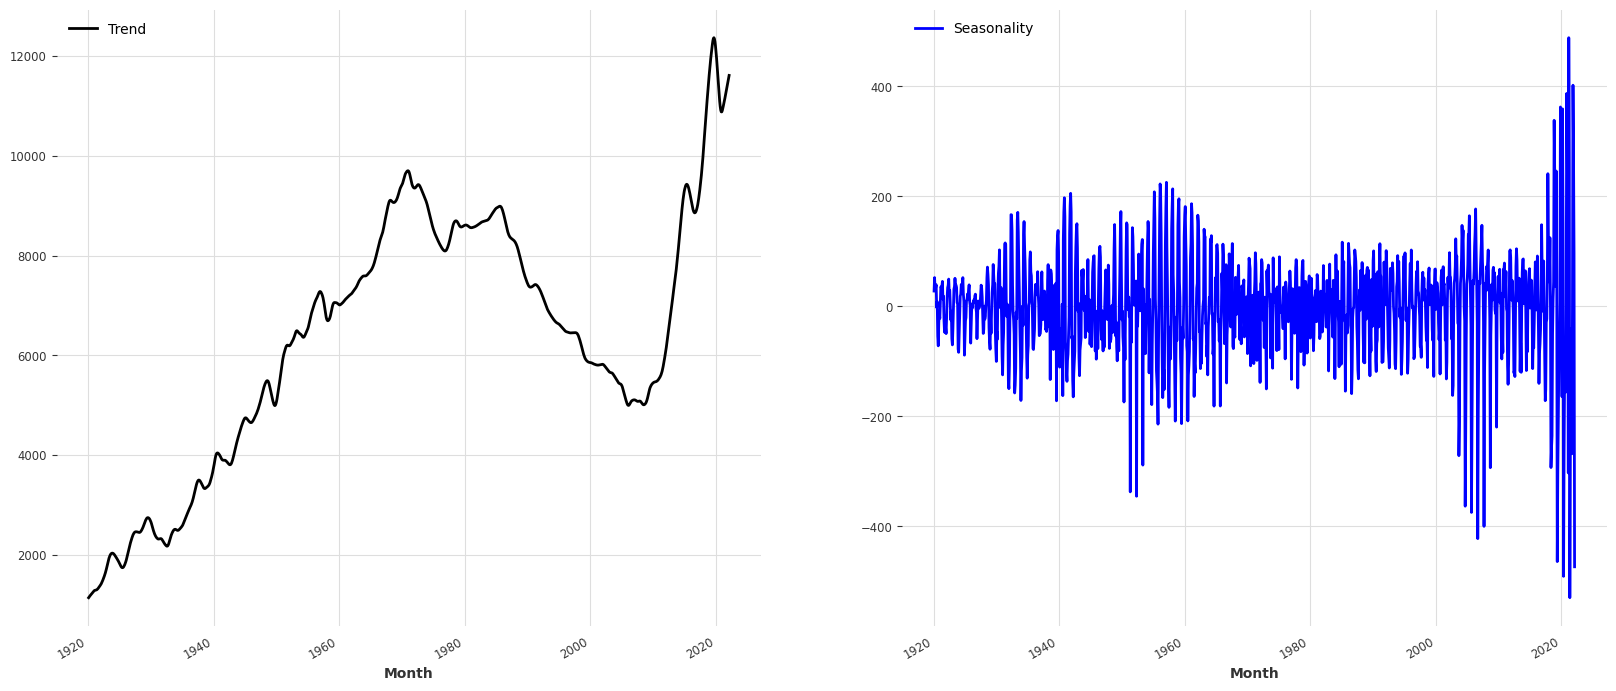

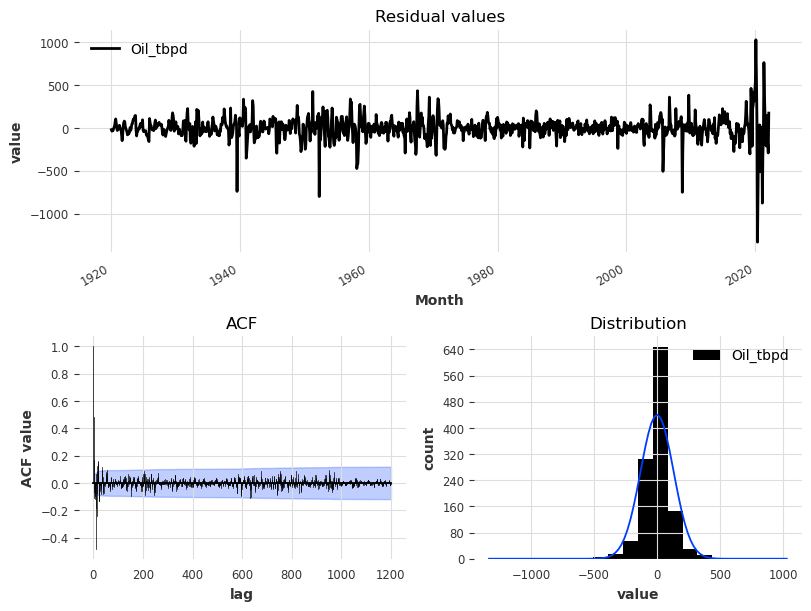

In [109]:
#EXTRACTING TREND AND SEASONALITY 
trend, seasonality = ds.extract_trend_and_seasonality(ts, method = 'STL', model = darts.utils.utils.ModelMode.ADDITIVE)
fig, ax = plt.subplots(1, 2, figsize = (20,8))
trend.plot(ax = ax[0], label = 'Trend')
seasonality.plot(ax = ax[1], label= 'Seasonality', c = 'blue')

#MAKING DATA STATIONARY 
stationary = ts - trend - seasonality
print('Stationarity p-value after subtracting trend and seasonality:', ds.stationarity_test_adf(stationary)[1])

residual_analysis = ds.plot_residuals_analysis(stationary, acf_max_lag= 1200)

plt.show()

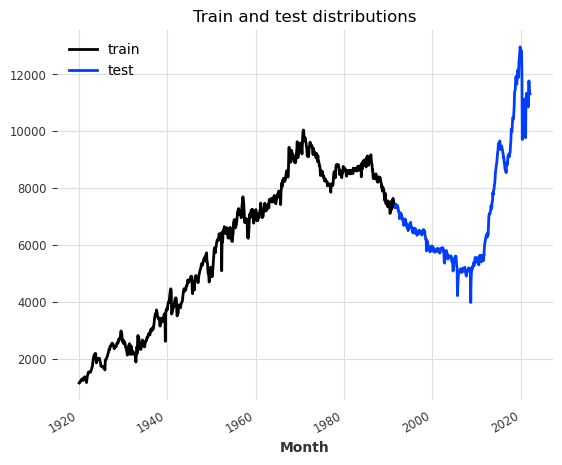

In [110]:
from darts.utils.model_selection import train_test_split
from darts.metrics.metrics import mape

train, test = train_test_split(ts, test_size= 0.3)

train.plot(label = 'train')
test.plot(label = 'test')
test_horizon = len(test)
plt.title('Train and test distributions')
plt.show()


performance_dict = dict()

In [111]:
for i in range(2, len(train) // 2): 
    seasonal, period = ds.check_seasonality(ts, m = i, max_lag = len(train))
    if seasonal: 
        print(i)
if not seasonal: 
    print('No seasonality detected in the train series')

No seasonality detected in the train series


In [141]:
#BASELINE MODEL

from darts.models import NaiveDrift
baseline = NaiveDrift()
baseline.fit(train)
baseline_pred = baseline.predict(test_horizon)

baseline_mape = mape(baseline_pred, test)
print('MAPE:', baseline_mape)

performance_dict[str(baseline)] = baseline_mape

MAPE: 22.75854289683352


In [113]:
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [114]:
#SIMPLE EXPONENTIAL SMOOTHING

from darts.models import ExponentialSmoothing
exp = ExponentialSmoothing(random_state = 1)
exp.fit(train)
exp_pred = exp.predict(test_horizon)

exp_mape = mape(exp_pred, test)
print('MAPE:', exp_mape)

performance_dict[str(exp)] = exp_mape

MAPE: 36.88660478117676


In [115]:
#ARIMA HYPERPARAMETER TUNING

from darts.models import ARIMA

best_mape = np.inf
best_arima = None
for p in range(5): 
    for d in range(5): 
        for q in range(5): 
            arima = ARIMA(p,d,q)
            arima.fit(train)
            arima_pred = arima.predict(test_horizon)
            score = mape(arima_pred, test)
            if score < best_mape: 
                best_mape = score
                best_arima = arima
                

best_arima.fit(train)
arima_pred = best_arima.predict(test_horizon)

arima_mape = mape(arima_pred, test)
print('MAPE:', arima_mape)

performance_dict[str(best_arima)] = arima_mape

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


MAPE: 22.510608600200886


In [116]:
#AUTO-ARIMA

from darts.models import AutoARIMA
from darts.utils.timeseries_generation import datetime_attribute_timeseries

autoarima = AutoARIMA(max_p = 30)
autoarima.fit(train, future_covariates= None)
autoarima_pred = autoarima.predict(test_horizon, future_covariates=None)

autoarima_mape = mape(autoarima_pred, test)
print('MAPE:', autoarima_mape)

performance_dict[str(autoarima)] = autoarima_mape

MAPE: 22.903812292144632


In [117]:
# LIGHT GBM MODEL 

from darts.models import LightGBMModel

gbm = LightGBMModel(lags = 600, random_state= 1, verbose = -1)
gbm.fit(train)
gbm_pred = gbm.predict(test_horizon)

gbm_mape = mape(gbm_pred, test)
print('MAPE:', gbm_mape)

performance_dict[str(gbm)] = gbm_mape

MAPE: 23.307314058058683


In [118]:
#CATBOOST MODEL 

from darts.models import CatBoostModel

cat = CatBoostModel(lags = 75, random_state= 1)
cat.fit(train)
cat_pred = cat.predict(test_horizon)

cat_mape = mape(cat_pred, test)
print('MAPE:' , cat_mape)

performance_dict['CatBoostModel(lags = 75, random_state= 1)'] = cat_mape  #Acted weird in the dictionary when using str(cat)

MAPE: 27.07636004128663


In [119]:
#RANDOM FOREST MODEL 

from darts.models import RandomForest

rf = RandomForest(lags = 72)
rf.fit(train)
rf_pred = rf.predict(test_horizon)

rf_mape = mape(rf_pred, test)
print('MAPE:', rf_mape)

performance_dict[str(rf)] = rf_mape

MAPE: 24.35541940737115


In [136]:
#NBEATS MODEL

from darts.models import NBEATSModel
import torch
torch.nn.L1Loss
nbeats_train = train.astype('float32')
nbeats_test = test.astype('float32')

nbeats = NBEATSModel(input_chunk_length = min(len(train) // 2, 50), 
                     output_chunk_length=test_horizon, 
                     n_epochs=100, 
                     random_state=1, 
                     batch_size = 120,
                     activation= 'SELU',
                     loss_fn = torch.nn.L1Loss())
nbeats.fit(nbeats_train)
nbeats_pred = nbeats.predict(test_horizon)

nbeats_mape = mape(nbeats_pred, nbeats_test).astype('float64')
print('MAPE:', nbeats_mape)

performance_dict['NBEATSModel'] = nbeats_mape

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | L1Loss           | 0      | train
1 | train_criterion | L1Loss           | 0      | train
2 | val_criterion   | L1Loss           | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.5 M  | train
-------------------------------------------------------------
6.5 M     Trainable params
1.6 K     Non-trainable params
6.5 M     Total params
25.860    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 29.721181869506836


In [121]:
from darts.models import Prophet

prophet = Prophet()
prophet.fit(train)
prophet_pred = prophet.predict(test_horizon)

prophet_mape = mape(prophet_pred, test)
print('MAPE:', prophet_mape)

performance_dict[str(prophet)] = prophet_mape

11:26:53 - cmdstanpy - INFO - Chain [1] start processing
11:26:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 30.133288703628647


In [143]:
performance_df = pd.DataFrame(list(performance_dict.items()), columns= ['Model','Score']).sort_values(by= 'Score')
performance_df

,Model,Score
2,"ARIMA(p=0, d=2, q=3)",22.510609
0,NaiveDrift(),22.758543
3,AutoARIMA(max_p=30),22.903812
4,"LGBMRegressor(random_state=1, verbose=-1)",23.307314
6,RandomForestRegressor(),24.355419
5,"CatBoostModel(lags = 75, random_state= 1)",27.076360
7,NBEATSModel,29.721182
8,Prophet(),30.133289
1,ExponentialSmoothing(random_state=1),36.886605
